In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis

 97% 20.0M/20.6M [00:03<00:00, 7.25MB/s]
100% 20.6M/20.6M [00:03<00:00, 6.42MB/s]


In [3]:
# this will extract the all folder in colab
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-movie-ratings-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [24]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 5.5 MB/s eta 0:00:00


In [26]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
import tensorflow as tf
warnings.filterwarnings("ignore")
import emoji
from textblob import TextBlob

In [5]:
# now read the data from pandas
data = pd.read_csv("movie.csv")

In [6]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
data.tail()

,text,label
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1
39999,"Why would this film be so good, but only gross...",1


In [8]:
# now check the shape
data.shape

(40000, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [10]:
# take some text data from text and check the pattern
data["text"].unique()

array(['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
       "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I

In [11]:
# check the null values in data
data.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
# check the duplicet values in data
data.duplicated().sum()

277

In [13]:
# drop the duplicet values
data.drop_duplicates(inplace=True)

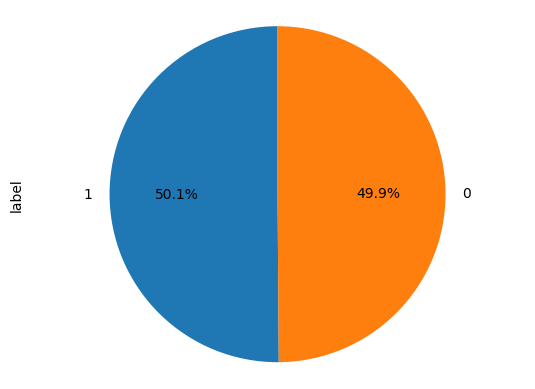

In [14]:
# now check the count of labels
data["label"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.show()
# 1 --> means positive
# 0 --> negative

In [27]:
from nltk.corpus import stopwords
import re
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [31]:
# now lets start preprossing steps on text
# Let's apply regex and do cleaning.
def data_cleaning(words):
    # Convert the input to lowercase
    words = str(words).lower()

    # Remove square brackets and their contents
    words = re.sub(r'\[.*?\]', '', words)

    # Remove URLs
    words = re.sub(r'https?://\S+|www\.\S+', '', words)

    # Remove HTML tags
    words = re.sub(r'<.*?>', '', words)

    # Remove punctuation
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)

    # Remove newline characters
    words = re.sub(r'\n', '', words)

    # Remove words containing numbers
    words = re.sub(r'\w*\d\w*', '', words)

    # Remove stopwords
    words = [word for word in words.split(' ') if word not in stopword]
    words = " ".join(words)

    # Stemming using Porter Stemmer
    words = [stemmer.stem(word) for word in words.split(' ')]
    words = " ".join(words)

    return words

In [32]:
data["text"] = data["text"].apply(data_cleaning)

In [33]:
# now saprate the dependent and independent features
X = data["text"]
y = data["label"]

In [44]:
# Now aply train test split to split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

31778 31778
7945 7945


In [45]:
print(f"shape of X_train :{X_train.shape}")
print(f"shape of y_train :{y_train.shape}")
print(f"shape of X_test :{X_test.shape}")
print(f"shape of y_test :{y_test.shape}")

shape of X_train :(31778,)
shape of y_train :(31778,)
shape of X_test :(7945,)
shape of y_test :(7945,)


In [47]:
vocab_size = len(set([word for sentense in data.text for word in sentense.split()]))
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 150094


In [48]:
from  tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Embedding,Flatten,SpatialDropout1D
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [49]:
# now create tokens
max_words = 100000
max_len = 600

tokenizer = Tokenizer(
    num_words = max_words,
)
tokenizer.fit_on_texts(X_train)

In [51]:
# intiger encoding
sequences = tokenizer.texts_to_sequences(X_train)

In [62]:
# now apply pading
padding = pad_sequences(sequences,maxlen=max_len)

In [65]:
# Creating model Architecture
model = Sequential()

# Adding an Embedding layer with 128-dimensional vectors for each word, input_length is set to max_len
model.add(Embedding(max_words, 128, input_length=max_len))

# Adding Spatial Dropout to prevent overfitting by dropping entire 1D feature maps
model.add(SpatialDropout1D(0.3))

# Adding the first LSTM layer with 100 units, dropout for input and recurrent connections is set to 0.2
model.add(GRU(250, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
# The return_sequences=True parameter is added to return the full sequence for the next LSTM layer

# Adding the first LSTM layer with 100 units, dropout for input and recurrent connections is set to 0.2
model.add(GRU(250, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
# The return_sequences=True parameter is added to return the full sequence for the next LSTM layer

# Adding a second LSTM layer with 100 units, dropout for input and recurrent connections is set to 0.2
model.add(GRU(250, dropout=0.3, recurrent_dropout=0.3))

# Adding a Dense layer with a single output unit and sigmoid activation for binary classification
model.add(Dense(1, activation="sigmoid"))

# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 128)          12800000  
                                                                 
 spatial_dropout1d (Spatial  (None, 600, 128)          0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 600, 250)          285000    
                                                                 
 gru_1 (GRU)                 (None, 600, 250)          376500    
                                                                 
 gru_2 (GRU)                 (None, 250)               376500    
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                        

In [66]:

# now compile the model

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam()
    ,metrics=['accuracy'])

In [68]:
# starting model training
history = model.fit(padding,y_train,batch_size=216,epochs = 2,validation_split=0.2)

Epoch 1/2
118/118 [==============================] - ETA: 0s - loss: 0.2364 - accuracy: 0.9056

UnimplementedError: ignored